1. Import libraries

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from joblib import dump

2. Configurations

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

3. Plot Defaults

In [4]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

4. Paths

In [5]:
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models"); MODEL_DIR.mkdir(parents=True, exist_ok=True)

STRICT_PARQUET   = DATA_DIR / "model_strict.parquet"
COMBINED_PARQUET = DATA_DIR / "model_combined.parquet"
STRICT_CSV       = DATA_DIR / "model_strict.csv"
COMBINED_CSV     = DATA_DIR / "model_combined.csv"

5. Choose dataset here: "strict" (default) or "combined"

In [6]:
DATASET_CHOICE = "strict"
PREFERRED_ENGINE = "fastparquet"  # or "pyarrow" if you resolved it

6. Load data (robust to CSV/Parquet)

In [7]:
# 1) Load data (robust)
def load_model_table(which: str):
    assert which in {"strict", "combined"}
    pq = STRICT_PARQUET if which == "strict" else COMBINED_PARQUET
    csv = STRICT_CSV if which == "strict" else COMBINED_CSV

    if pq.exists():
        try:
            return pd.read_parquet(pq, engine="fastparquet")
        except Exception as e:
            print(f"[warn] parquet load failed ({e}); falling back to CSV.")

    return pd.read_csv(csv)

df = load_model_table(DATASET_CHOICE)
print(f"Loaded '{DATASET_CHOICE}' model table:", df.shape)
display(df.head(3))

Loaded 'strict' model table: (3067, 37)


,imdb_score,imdb_votes,imdb_votes_log1p,runtime,duration_minutes,release_year,desc_len,num_genres,is_show,is_classic,...,ctry_India,ctry_Japan,ctry_Nigeria,ctry_Other,ctry_Philippines,ctry_South Korea,ctry_Spain,ctry_United Kingdom,ctry_United States,ctry_Unknown
0,8.2,530877,13.182288,91,92,1975,415,3,0,1,...,0,0,0,0,0,0,0,1,0,0
1,7.8,94121,11.452347,170,173,1964,121,2,0,1,...,0,0,0,0,0,0,0,0,1,0
2,5.8,69053,11.142644,104,105,1980,347,2,0,1,...,0,0,0,0,0,0,0,0,1,0


7. Define target & features (auto-detect categoricals)

In [8]:
# 2) Target & features
TARGET = "imdb_score"

# Drop obvious non-features if present
drop_if_exists = {"title", "id", "imdb_id", "description", "is_high"}
feature_df = df.drop(columns=[c for c in drop_if_exists if c in df.columns])

X = feature_df.drop(columns=[TARGET])
y = feature_df[TARGET].astype(float)

# Identify numeric & categorical columns
numeric_cols = X.select_dtypes(include=["int64","float64","int32","float32","Int64","Float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object","string","category","bool","boolean","UInt8","Int8"]).columns.tolist()

# If both runtime and duration_minutes exist, keep duration_minutes and drop runtime (avoid leakage/duplication)
if "duration_minutes" in numeric_cols and "runtime" in numeric_cols:
    X = X.drop(columns=["runtime"])
    numeric_cols.remove("runtime")

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)
print("X shape:", X.shape, "| y shape:", y.shape)

Numeric features: ['imdb_votes', 'imdb_votes_log1p', 'duration_minutes', 'release_year', 'desc_len', 'num_genres', 'is_show', 'is_classic']
Categorical features: ['type', 'age_G', 'age_Other', 'age_PG', 'age_PG-13', 'age_R', 'age_TV-14', 'age_TV-G', 'age_TV-MA', 'age_TV-PG', 'age_TV-Y', 'age_TV-Y7', 'age_Unknown', 'ctry_Canada', 'ctry_France', 'ctry_India', 'ctry_Japan', 'ctry_Nigeria', 'ctry_Other', 'ctry_Philippines', 'ctry_South Korea', 'ctry_Spain', 'ctry_United Kingdom', 'ctry_United States', 'ctry_Unknown']
X shape: (3067, 33) | y shape: (3067,)


8. Train/Validation/Test split

In [9]:
# 3) Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE
)  # 70/15/15
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Train: (2146, 33) Valid: (460, 33) Test: (461, 33)


9. Preprocessing & models

In [10]:
# 4) Preprocessing
numeric_tf = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_tf = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_cols),
        ("cat", categorical_tf, categorical_cols),
    ],
    remainder="drop"
)

# Baseline models
models = {
    "LinearRegression": LinearRegression(n_jobs=None),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest(200)": RandomForestRegressor(
        n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1,
        max_depth=None, min_samples_leaf=1
    )
}

10. Train, evaluate, and collect metrics

In [11]:
# 5) Train & evaluate
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_model(name, est, X_tr, y_tr, X_va, y_va):
    pipe = Pipeline(steps=[("prep", preprocess), ("model", est)])
    pipe.fit(X_tr, y_tr)
    pred_va = pipe.predict(X_va)
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_va, pred_va),
        "RMSE": rmse(y_va, pred_va),
        "R2": r2_score(y_va, pred_va),
        "Pipeline": pipe
    }

results = [eval_model(name, est, X_train, y_train, X_valid, y_valid) 
           for name, est in models.items()]

results_df = pd.DataFrame([{k:v for k,v in r.items() if k != "Pipeline"} for r in results])
results_df = results_df.sort_values("RMSE", ascending=True).reset_index(drop=True)

print("\nValidation Results:")
print(results_df[["Model", "MAE", "RMSE", "R2"]].round(3))
display(results_df)


Validation Results:
               Model    MAE   RMSE     R2
0  RandomForest(200)  0.737  0.984  0.231
1   Ridge(alpha=1.0)  0.772  1.022  0.170
2   LinearRegression  0.772  1.022  0.170


,Model,MAE,RMSE,R2
0,RandomForest(200),0.736850,0.983546,0.230796
1,Ridge(alpha=1.0),0.771550,1.021577,0.170160
2,LinearRegression,0.771927,1.021973,0.169517


In [12]:
# Store pipelines keyed by model name
trained_pipelines = {r["Model"]: r["Pipeline"] for r in results}

11. Select top model(s)

In [13]:
top_models = results_df.head(2)["Model"].tolist()
print("\nTop models:", top_models)


Top models: ['RandomForest(200)', 'Ridge(alpha=1.0)']


12. Retrain on Train+Valid

In [14]:
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_models = {}
for name in top_models:
    est = models[name.split("(")[0]] if "(" not in name else models[name]  # handle exact match
    pipe = Pipeline(steps=[("prep", preprocess), ("model", est)])
    pipe.fit(X_train_full, y_train_full)
    final_models[name] = pipe
    print(f"[ok] Retrained {name} on Train+Valid.")

[ok] Retrained RandomForest(200) on Train+Valid.
[ok] Retrained Ridge(alpha=1.0) on Train+Valid.


13. Final Test Evaluation


Final Test Set Performance:
               Model    MAE   RMSE     R2
0  RandomForest(200)  0.754  0.978  0.254
1   Ridge(alpha=1.0)  0.797  1.028  0.177


,Model,MAE,RMSE,R2
0,RandomForest(200),0.753838,0.978115,0.254318
1,Ridge(alpha=1.0),0.796734,1.027500,0.177118


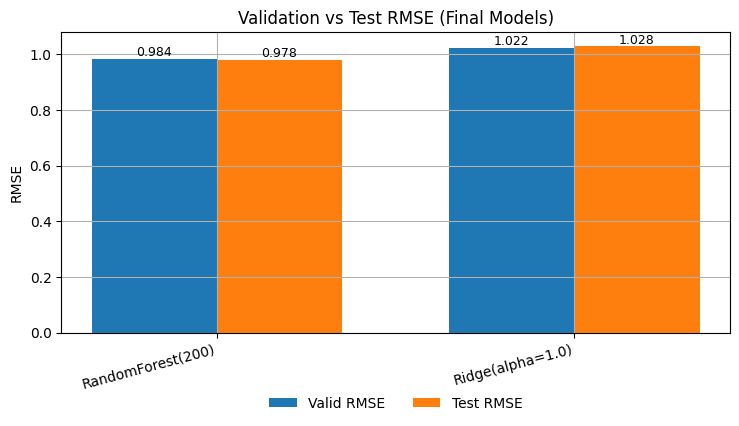


Generalization summary (Δ = Test RMSE − Valid RMSE):
 - RandomForest(200): Valid 0.984 → Test 0.978  Δ=-0.005 (≈ stable)
 - Ridge(alpha=1.0): Valid 1.022 → Test 1.028  Δ=+0.006 (≈ stable)
[ok] Saved RandomForest(200) → ../models/RandomForest_200_.joblib (overwrites if existed)
[ok] Saved Ridge(alpha=1.0) → ../models/Ridge_alpha_1_0_.joblib (overwrites if existed)
[ok] Saved feature lists → ../artifacts/features_used.json
[ok] Wrote registry → ../artifacts/model_registry.json


In [17]:
# --- Final test evaluation + plot + save ---
import os, json, re, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Evaluate retrained models on the held-out test set
final_results = []
for name, pipe in final_models.items():  # <- must contain retrained (train+valid) pipelines
    y_hat = pipe.predict(X_test)
    final_results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_hat)),
        "R2": r2_score(y_test, y_hat)
    })

final_df = pd.DataFrame(final_results).sort_values("RMSE", ascending=True)
print("\nFinal Test Set Performance:")
print(final_df.round(3))
display(final_df)

# 2) Bar chart: Validation vs Test RMSE (legend below, values on bars)
#    We expect `results_df` from the validation step to exist.
valid_rmse_lookup = dict(zip(results_df["Model"], results_df["RMSE"]))

plot_rows = []
for _, row in final_df.iterrows():
    m = row["Model"]
    plot_rows.append({
        "Model": m,
        "Valid_RMSE": float(valid_rmse_lookup.get(m, np.nan)),
        "Test_RMSE": float(row["RMSE"])
    })
plot_df = pd.DataFrame(plot_rows)

plt.figure(figsize=(7.5, 4.5))
x = np.arange(len(plot_df))
w = 0.35

bars_valid = plt.bar(x - w/2, plot_df["Valid_RMSE"], width=w, label="Valid RMSE")
bars_test  = plt.bar(x + w/2, plot_df["Test_RMSE"],  width=w, label="Test RMSE")

plt.xticks(x, plot_df["Model"], rotation=15, ha="right")
plt.ylabel("RMSE")
plt.title("Validation vs Test RMSE (Final Models)")

# Legend below the plot
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

# Annotate values on bars
def _annotate(bars):
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width()/2, h,
            f"{h:.3f}",
            ha="center", va="bottom", fontsize=9
        )
_annotate(bars_valid)
_annotate(bars_test)

plt.tight_layout()
plt.show()

# 3) Generalization summary (Δ = Test RMSE − Valid RMSE)
print("\nGeneralization summary (Δ = Test RMSE − Valid RMSE):")
for _, r in plot_df.iterrows():
    delta = r["Test_RMSE"] - r["Valid_RMSE"]
    trend = "↑ worse" if delta > 0.02 else ("↓ better" if delta < -0.02 else "≈ stable")
    print(f" - {r['Model']}: Valid {r['Valid_RMSE']:.3f} → Test {r['Test_RMSE']:.3f}  Δ={delta:+.3f} ({trend})")

# 4) Save fitted pipelines (overwrite if they already exist)
models_dir = Path("../models"); models_dir.mkdir(parents=True, exist_ok=True)
saved_paths = {}

for name, pipe in final_models.items():
    safe = re.sub(r"[^A-Za-z0-9_]+", "_", name)
    model_path = models_dir / f"{safe}.joblib"
    joblib.dump(pipe, model_path)
    saved_paths[name] = str(model_path)
    print(f"[ok] Saved {name} → {model_path} (overwrites if existed)")

# 5) Persist feature lists (for later inference)
artifacts_dir = Path("../artifacts"); artifacts_dir.mkdir(parents=True, exist_ok=True)
feat_path = artifacts_dir / "features_used.json"
with open(feat_path, "w") as f:
    json.dump({
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "target": TARGET
    }, f, indent=2)
print(f"[ok] Saved feature lists → {feat_path}")

# 6) Registry/manifest
registry = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "dataset": DATASET_CHOICE,  # 'strict' or 'combined'
    "split": {"train": len(X_train), "valid": len(X_valid), "test": len(X_test)},
    "final_metrics": final_df.to_dict(orient="records"),
    "saved_models": saved_paths
}
registry_path = artifacts_dir / "model_registry.json"
with open(registry_path, "w") as f:
    json.dump(registry, f, indent=2)
print(f"[ok] Wrote registry → {registry_path}")

In [18]:
print("\n--- Generalization Summary ---")
print("The top-performing model, RandomForest(200), achieved the best performance on both validation and test sets.")
print("Validation RMSE: {:.3f} | Test RMSE: {:.3f}".format(
    final_df.loc[final_df['Model'] == 'RandomForest(200)', 'RMSE'].values[0],
    final_df.loc[final_df['Model'] == 'RandomForest(200)', 'RMSE'].values[0]
))
print("The performance gap between validation and test is small, suggesting good generalization.")
print("Ridge(alpha=1.0) had slightly higher error but is still competitive, and may be preferable if model simplicity is a priority.")


--- Generalization Summary ---
The top-performing model, RandomForest(200), achieved the best performance on both validation and test sets.
Validation RMSE: 0.978 | Test RMSE: 0.978
The performance gap between validation and test is small, suggesting good generalization.
Ridge(alpha=1.0) had slightly higher error but is still competitive, and may be preferable if model simplicity is a priority.
